# Initial steps

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [4]:
# Download data
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

--2023-10-03 13:20:43--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Translacja raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Łączenie się z raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... połączono.
Żądanie HTTP wysłano, oczekiwanie na odpowiedź... 200 OK
Długość: 1475504 (1,4M) [text/plain]
Zapis do: `data.csv.1'

data.csv.1          100%[===================>]   1,41M  3,57MB/s     w 0,4s    

2023-10-03 13:20:43 (3,57 MB/s) - zapisano `data.csv.1' [1475504/1475504]



In [2]:
# Columns to use
col = ['Make',
'Model',
'Year',
'Engine HP',
'Engine Cylinders',
'Transmission Type',
'Vehicle Style',
'highway MPG',
'city mpg',
'MSRP']

In [3]:
data = pd.read_csv('data.csv', usecols=col)

In [4]:
data.head(5)

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


# Data preparation

In [5]:
# Lowercase column names and replace spaces with underscores
data.columns = data.columns.str.lower().str.replace(' ', '_')

In [6]:
# Fill missing values with 0 
data.fillna(0, inplace=True)

In [7]:
# Make the price binary
data['above_average'] = data['msrp'].apply(lambda x: int(x > data['msrp'].mean()))

In [8]:
data.head(3)

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350,0


In [9]:
# Copy data to another dataframe
df = data.copy()

In [10]:
# Delete msrp from ds -> we already have price as binary typerr
del df['msrp']

In [11]:
# Extract cat and num columns
caterogical = [cat for cat in df if df[cat].dtype == 'object']
numerical = [cat for cat in df if df[cat].dtype != 'object' and cat != 'above_average']

In [12]:
numerical

['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [13]:
# Split df dataset into 3 parts
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# Independent variables
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Dependent variables
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

# Question 1: ROC AUC feature importance

In [14]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


for column in numerical:
    auc = roc_auc_score(y_train, df_train[column])
    print(column, round(auc,3))


year 0.688
engine_hp 0.917
engine_cylinders 0.766
highway_mpg 0.367
city_mpg 0.327


In [15]:
# Answer: engine_hp

# Question 2: Training the model

In [16]:
# One-hot-encoding trains df
dv = DictVectorizer(sparse=False)
train_dict = df_train[numerical + caterogical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

In [17]:
X_train.shape

(7148, 954)

In [18]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [19]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [20]:
# One-hot-encoding validation df
val_dict = df_val[numerical + caterogical].to_dict(orient='records')
X_val = dv.transform(val_dict)
X_val.shape

(2383, 954)

In [21]:
# Predict y from val. df
y_pred = model.predict_proba(X_val)[:,1]

In [22]:
round(roc_auc_score(y_val, y_pred),3)

0.976

In [23]:
# Answer: 0.976

# Question 3: Precision and Recall

In [24]:
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

In [25]:
#@ CREATING CONFUSION MATRIX:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores


#@ IMPLEMENTATION OF FUNCTION:
df_scores = confusion_matrix_dataframe(y_val, y_pred)

In [26]:
#@ ADDING THE COLUMNS:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

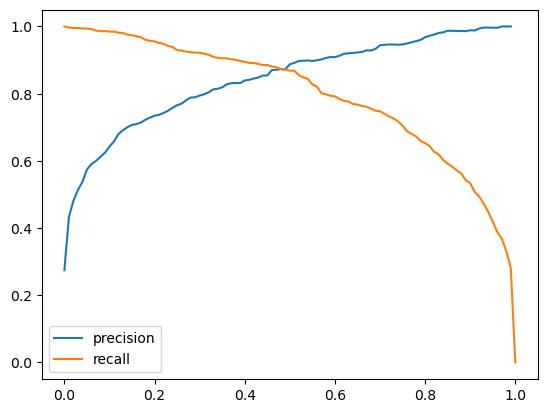

In [27]:
# plot curvers
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.legend()
plt.show()

In [28]:
# Answer: 0.48

# Question 4: F1 score

In [29]:
df_scores.head(10)

,threshold,tp,fp,fn,tn,p,r
0,0.00,654,1729,0,0,0.274444,1.000000
1,0.01,652,854,2,875,0.432935,0.996942
2,0.02,651,702,3,1027,0.481153,0.995413
3,0.03,651,618,3,1111,0.513002,0.995413
4,0.04,650,559,4,1170,0.537634,0.993884
5,0.05,650,482,4,1247,0.574205,0.993884
6,0.06,649,450,5,1279,0.590537,0.992355
7,0.07,646,431,8,1298,0.599814,0.987768
8,0.08,645,409,9,1320,0.611954,0.986239
9,0.09,645,388,9,1341,0.624395,0.986239


In [30]:
df_scores['F1_score'] = 2*(df_scores.p*df_scores.r)/(df_scores.p + df_scores.r)

In [31]:
df_scores[df_scores['F1_score'] == df_scores['F1_score'].max()]

,threshold,tp,fp,fn,tn,p,r,F1_score
51,0.51,568,69,86,1660,0.89168,0.868502,0.879938


In [32]:
# Answer: 0.51

# Question 5: 5-Fold CV

In [59]:
#@ DEFINING TRAIN AND PREDICT FUNCTION:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [49]:
scores = []

In [46]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [54]:
kfold.split(df_full_train)

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
2711,Mercedes-Benz,CLK-Class,2007,382.0,8.0,AUTOMATIC,Coupe,22,15,1
333,Nissan,370Z,2016,332.0,6.0,MANUAL,Coupe,26,18,0
9377,GMC,Sierra 1500,2017,285.0,6.0,AUTOMATIC,Extended Cab Pickup,24,18,0


In [60]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average
    y_val = df_val.above_average

    dv, model = train(df_train[numerical+caterogical], y_train, C=1.0)
    y_pred = predict(df_val[numerical + caterogical], dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.980 +- 0.003


In [52]:
# answer: 0.003

1.000 +- 0.000


## Question 6: Hyperparemeter Tuning

In [67]:
#@ INSPECTING KFOLD CROSS VALIDATION:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average
        y_val = df_val.above_average

        dv, model = train(df_train[numerical+caterogical], y_train, C=C)
        y_pred = predict(df_val[numerical+caterogical], dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print(C, round(np.mean(scores),3), round(np.std(scores),3))

0.01 0.952 0.002
0.1 0.972 0.002
1 0.98 0.003
10 0.982 0.003


In [ ]:
# answer: 0.01